# Ladi-Vton-Integrated

This is for integrating all components required for utilizing ladi-vton with just a image of cloth and person.

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/python_env'
# Colab Notebooks 안에 python_env 폴더에 패키지 저장
# os.symlink('/content/drive/MyDrive/Colab Notebooks/python_env', my_path)
# !mkdir $my_path
!ln -s '/content/drive/MyDrive/ColabNotebooks/python_env' $my_path
sys.path.insert(0, my_path)

Mounted at /content/drive


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import os
import sys
from PIL import Image
import torch
import time


## 기타 prerequisite 설치(첫 실행에 한번만)

In [3]:
# requirements
#!pip install --target=$my_path packages

!pip install --target=$my_path cython
!pip install --target=$my_path git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.1 MB/s eta 0:00:00
  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-h44ch0z7
  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-h44ch0z7
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=375391 sha256=3a05d6eb0664bf4268e58f534a8c2fff51889368d5905008ef7cc401263cc9ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-j66t0vp9/wheels/8e/1a/5f/0c984ae3d65a4d7da4ba3407d2a8d8c8e85dd55f84d4936f04
Successfully built pycocotools


## Openpose 설치(실패)

In [ ]:
# install openpose
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
# build openpose
!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

In [19]:
openpose_path = '/content/drive/MyDrive/ColabNotebooks/python_env/openpose'
# !mv openpose '{openpose_path}'
# # openpose 사용법 예시
# !cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# # convert the result into MP4
# !ffmpeg -y -loglevel info -i openpose.avi output.mp4

In [11]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

In [20]:
!export DISPLAY=:0.0
!cd '{openpose_path}' && ./build/examples/openpose/openpose.bin --help

openpose.bin: Warning: SetUsageMessage() never called

  Flags from ./src/logging.cc:
    -alsologtoemail (log messages go to these email addresses in addition to
      logfiles) type: string default: ""
    -alsologtostderr (log messages go to stderr in addition to logfiles)
      type: bool default: false
    -colorlogtostderr (color messages logged to stderr (if supported by
      terminal)) type: bool default: false
    -drop_log_memory (Drop in-memory buffers of log contents. Logs can grow
      very quickly and they are rarely read before they need to be evicted from
      memory. Instead, drop them from memory as soon as they are flushed to
      disk.) type: bool default: true
    -log_backtrace_at (Emit a backtrace when logging at file:linenum.)
      type: string default: ""
    -log_dir (If specified, logfiles are written into this directory instead of
      the default logging directory.) type: string default: ""
    -log_link (Put additional links to the log files in this 

In [25]:
# prepare to use openpose
img_input = '/content/drive/MyDrive/datasets/ladi_data/image/'
img_output = '/content/drive/MyDrive/datasets/ladi_data/openpose_img/'
json_output = '/content/drive/MyDrive/datasets/ladi_data/openpose_json/'
caffemodel_path = 'pose/coco/pose_iter_440000.caffemodel'
openpose_path = "/content/drive/MyDrive/ColabNotebooks/python_env/openpose/"

!cp '{openpose_path}'/build/src/openpose/libopenpose.so.1.7.0 /usr/local/lib
!cp '{openpose_path}'/build/caffe/lib/libcaffe.so.1.0.0 /usr/local/lib
!sudo ldconfig

!chmod +x '{openpose_path}/build/examples/openpose/openpose.bin'

!cd "/content/drive/MyDrive/ColabNotebooks/python_env/openpose/" && ./build/examples/openpose/openpose.bin --model_pose COCO --caffemodel_path '{caffemodel_path}' --display 0 --disable_blending --image_dir '{img_input}' --write_json '{json_output}' --write_images '{img_output}'

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
F1115 15:23:24.691458  6431 cudnn_conv_layer.cpp:53] Check failed: status == CUDNN_STATUS_SUCCESS (1 vs. 0)  CUDNN_STATUS_NOT_INITIALIZED
*** Check failure stack trace: ***
    @     0x79ef85603b03  google::LogMessage::Fail()
    @     0x79ef8560b9d1  google::LogMessage::SendToLog()
    @     0x79ef856037c2  google::LogMessage::Flush()
    @     0x79ef8560578f  go

## Detectron2 설치

In [18]:
# install detectron2

!git clone https://github.com/facebookresearch/detectron2.git
!pip install -e detectron2 --target=$my_path

Cloning into 'detectron2'...
remote: Enumerating objects: 15280, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15280 (delta 0), reused 1 (delta 0), pack-reused 15275
Receiving objects: 100% (15280/15280), 6.17 MiB | 13.87 MiB/s, done.
Resolving deltas: 100% (11115/11115), done.
You can inspect what was checked out with 'git status'
and retry with 'git restore --source=HEAD :/'

^C
Obtaining file:///content/drive/MyDrive/ColabNotebooks/python_env/openpose/detectron2
ERROR: file:///content/drive/MyDrive/ColabNotebooks/python_env/openpose/detectron2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## Human parsing 설치

In [ ]:
# Prerequisite
!pip install -U --no-cache-dir gdown --pre -qq
!pip install ninja -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
# install Self-Correction Human Parsing
!git clone https://github.com/GoGoDuck912/Self-Correction-Human-Parsing.git

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (149/149), done.


Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/drive/MyDrive/Colab Notebooks/lip_final.pth
100%|██████████| 267M/267M [00:02<00:00, 113MB/s]


'/content/drive/MyDrive/Colab Notebooks/lip_final.pth'

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', '/content/drive/MyDrive/Colab Notebooks/lip_final.pth', quiet=False)

In [9]:
test_imgs = '/content/drive/MyDrive/datasets/ladi_data/image'
sorted(os.listdir(test_imgs))

['00006_00.jpg',
 '00008_00.jpg의 사본.jpg',
 '00013_00.jpg의 사본.jpg',
 '00017_00.jpg의 사본.jpg',
 '00034_00.jpg의 사본.jpg',
 '00035_00.jpg의 사본.jpg',
 '00055_00.jpg의 사본.jpg',
 '00057_00.jpg의 사본.jpg',
 '00064_00.jpg의 사본.jpg',
 '00067_00.jpg의 사본.jpg']

In [ ]:
from PIL import Image
import time

checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/lip_final.pth'
# img_input = 'Data_preprocessing/test_img/'
# img_output = 'Data_preprocessing/test_label/'
img_input = '/content/drive/MyDrive/datasets/ladi_data/image/'
img_output = '/content/drive/MyDrive/datasets/ladi_data/image-parse-v3/'

# img_name = f'img_{int(time.time())}.png'
#
# img_path = os.path.join(test_imgs, sorted(os.listdir(test_imgs))[0])
# img = Image.open(img_path)
# img = img.resize((192,256), Image.BICUBIC)

# img_path = os.path.join(img_input, img_name)
# if not os.path.exists(img_input):
#   os.makedirs(img_input)
# img.save(img_path)

!python3 Self-Correction-Human-Parsing/simple_extractor.py --dataset 'lip' --model-restore '{checkpoint_path}' --input-dir '{img_input}' --output-dir '{img_output}'


# pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))

## Ladi-Vton

- Original: https://github.com/miccunifi/ladi-vton

In [3]:
# Settinbg ladi-vton
!git clone https://github.com/k1064190/ladi-vton.git


# Download model from (https://www.kaggle.com/datasets/changethetuneman/openpose-model/) required
!cp '/content/drive/MyDrive/datasets/archive_2/pose_iter_440000.caffemodel' '/content/ladi-vton/pose/'

# Dataset
dataset_path = "/content/drive/MyDrive/datasets/ladi-vton/"

Cloning into 'ladi-vton'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 117 (delta 27), reused 24 (delta 20), pack-reused 78
Receiving objects: 100% (117/117), 1.54 MiB | 15.81 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
%cd ladi-vton

In [9]:
!git pull

from predict_pose import generate_pose_keypoints

# prepare to use openpose
img_input = '/content/drive/MyDrive/datasets/ladi_data/image/'
img_output = '/content/drive/MyDrive/datasets/ladi_data/openpose_img/'
json_output = '/content/drive/MyDrive/datasets/ladi_data/openpose_json/'


img_name = sorted(os.listdir(img_input))[1]
print(img_name)
img_path = os.path.join(img_input, img_name)
print(img_path)
pose_path = os.path.join(json_output, img_name.replace('.jpg', '_keypoints.json'))

generate_pose_keypoints(img_path, pose_path)

Already up to date.
00008_00.jpg
/content/drive/MyDrive/datasets/ladi_data/image/00008_00.jpg
File saved at /content/drive/MyDrive/datasets/ladi_data/openpose_json/00008_00_keypoints.json


## TODO: predict_pose 한번에 여러 이미지 하도록 수정. 옷 masking

In [ ]:
!pip install opencv-python==4.7.0.72 diffusers==0.14.0 transformers==4.27.3 accelerate==0.18.0 clean-fid==0.1.35 torchmetrics[image]==0.11.4 wandb==0.14.0 matplotlib==3.7.1 tqdm xformers

In [ ]:
# run inference with prepared data
!python src/inference.py --dataset vitonhd --vitonhd_dataroot $dataset_path --output_dir output --test_order unpaired --batch_size 2

In [ ]:
!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

In [ ]:
!git clone https://github.com/levindabhi/Self-Correction-Human-Parsing-for-ACGPN.git
!git clone https://github.com/levindabhi/U-2-Net.git

## 사전학습 모델 다운로드

### 포즈 예측 모델

In [ ]:
!gdown 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko -O pose/pose_iter_440000.caffemodel

Downloading...
From: https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
100% 209M/209M [00:03<00:00, 54.7MB/s]


### 휴먼 세그멘테이션 마스크 생성 모델

In [ ]:
gdown.download('https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH', 'lip_final.pth', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/ACGPN/lip_final.pth
100%|██████████| 267M/267M [00:05<00:00, 51.9MB/s]


'lip_final.pth'

### U2Net 모델

옷 마스크 추출 모델

In [ ]:
%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp

!gdown 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

import u2net_load
import u2net_run

u2net = u2net_load.model(model_name='u2netp')

%cd ..

/content/ACGPN/U-2-Net
mkdir: cannot create directory ‘saved_models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
100% 4.68M/4.68M [00:00<00:00, 63.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
100% 176M/176M [00:01<00:00, 98.4MB/s]
...load U2NEP---4.7 MB
/content/ACGPN


### ACGPN 모델

In [ ]:
!mkdir checkpoints

gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx', output='checkpoints/ACGPN_checkpoints.zip', quiet=False)

!unzip checkpoints/ACGPN_checkpoints.zip -d checkpoints

Downloading...
From: https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
100%|██████████| 524M/524M [00:04<00:00, 114MB/s]


Archive:  checkpoints/ACGPN_checkpoints.zip
   creating: checkpoints/label2city/
  inflating: checkpoints/label2city/latest_net_G.pth  
  inflating: checkpoints/label2city/latest_net_G1.pth  
  inflating: checkpoints/label2city/latest_net_G2.pth  
  inflating: checkpoints/label2city/latest_net_U.pth  
  inflating: checkpoints/label2city/opt.txt  


## VITON 데이터셋

https://drive.google.com/uc?id=1tE7hcVFm8Td8kRh5iYRBSDFdvZIkbUIR

## AI허브 패션 데이터셋

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78

![](https://aihub.or.kr/web-nas/aihub21/files/public/inline-images/65_%ED%8C%A8%EC%85%98%EC%83%81%ED%92%88%EB%B0%8F%EC%B0%A9%EC%9A%A9%EC%98%81%EC%83%81_%EB%8C%80%ED%91%9C%EB%8F%84.PNG)

## 전처리

### 옷 마스크 추출

In [ ]:
sorted(os.listdir('inputs/cloth'))

['001056_1.jpg']

Generating mask for: cloth_1670552521.png
Saving output at Data_preprocessing/test_edge/cloth_1670552521.png


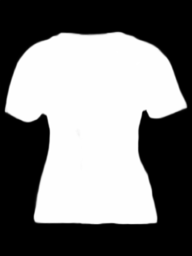

In [ ]:
cloth_name = f'cloth_{int(time.time())}.png'

cloth_path = os.path.join('inputs/cloth', sorted(os.listdir('inputs/cloth'))[0])
cloth = Image.open(cloth_path)
cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')

Image.open(f'Data_preprocessing/test_edge/{cloth_name}')

### 모델 포즈, 세그멘테이션

In [ ]:
sorted(os.listdir('inputs/img'))

['000997_0.jpg']

In [ ]:
img_name = f'img_{int(time.time())}.png'

img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
img = Image.open(img_path)
img = img.resize((192,256), Image.BICUBIC)

img_path = os.path.join('Data_preprocessing/test_img', img_name)
img.save(img_path)

!python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'

pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
generate_pose_keypoints(img_path, pose_path)

100% 1/1 [00:01<00:00,  1.75s/it]
File saved at Data_preprocessing/test_pose/img_1670552538_keypoints.json


## 추론

In [ ]:
!rm -rf Data_preprocessing/test_pairs.txt
with open('Data_preprocessing/test_pairs.txt', 'w') as f:
    f.write(f'{img_name} {cloth_name}')

In [ ]:
!python test.py

?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

## 결과

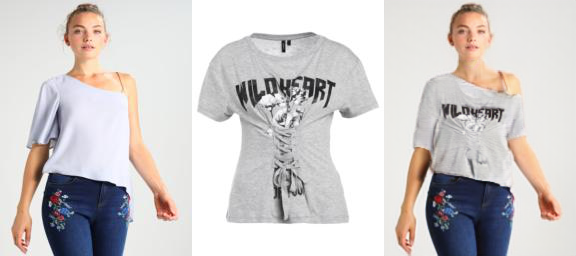

In [ ]:
output_grid = np.concatenate([
    np.array(Image.open(f'Data_preprocessing/test_img/{img_name}')),
    np.array(Image.open(f'Data_preprocessing/test_color/{cloth_name}')),
    np.array(Image.open(f'results/test/try-on/{img_name}'))
], axis=1)

image_grid = Image.fromarray(output_grid)

image_grid